In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

from imutils import paths
from pathlib import Path
import os
import sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import unpickle, save_pickle
from cub_tools.transforms import makeDefaultTransforms

In [2]:
# Script runtime options
model = 'swin_base_patch4_window12_384'
data_root_dir = '../data'
model_root_dir = '../models'
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

In [3]:
# Get data transforms
data_transforms = makeDefaultTransforms(img_crop_size=384, img_resize=512)

In [4]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

print('Number of data')
print('========================================')
for dataset in dataset_sizes.keys():
    print(dataset,' size:: ', dataset_sizes[dataset],' images')

print('')
print('Number of classes:: ', len(class_names))
print('========================================')
for i_class, class_name in enumerate(class_names):
    print('{} :: {} :: {}'.format(i_class,class_name,(np.array(image_datasets['test'].targets) == i_class).sum()))


Number of data
test  size::  5794  images

Number of classes::  200
0 :: 001.Black_footed_Albatross :: 30
1 :: 002.Laysan_Albatross :: 30
2 :: 003.Sooty_Albatross :: 28
3 :: 004.Groove_billed_Ani :: 30
4 :: 005.Crested_Auklet :: 14
5 :: 006.Least_Auklet :: 11
6 :: 007.Parakeet_Auklet :: 23
7 :: 008.Rhinoceros_Auklet :: 18
8 :: 009.Brewer_Blackbird :: 29
9 :: 010.Red_winged_Blackbird :: 30
10 :: 011.Rusty_Blackbird :: 30
11 :: 012.Yellow_headed_Blackbird :: 26
12 :: 013.Bobolink :: 30
13 :: 014.Indigo_Bunting :: 30
14 :: 015.Lazuli_Bunting :: 28
15 :: 016.Painted_Bunting :: 28
16 :: 017.Cardinal :: 27
17 :: 018.Spotted_Catbird :: 15
18 :: 019.Gray_Catbird :: 29
19 :: 020.Yellow_breasted_Chat :: 29
20 :: 021.Eastern_Towhee :: 30
21 :: 022.Chuck_will_Widow :: 26
22 :: 023.Brandt_Cormorant :: 29
23 :: 024.Red_faced_Cormorant :: 22
24 :: 025.Pelagic_Cormorant :: 30
25 :: 026.Bronzed_Cowbird :: 30
26 :: 027.Shiny_Cowbird :: 30
27 :: 028.Brown_Creeper :: 29
28 :: 029.American_Crow :: 30
29 ::

In [5]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


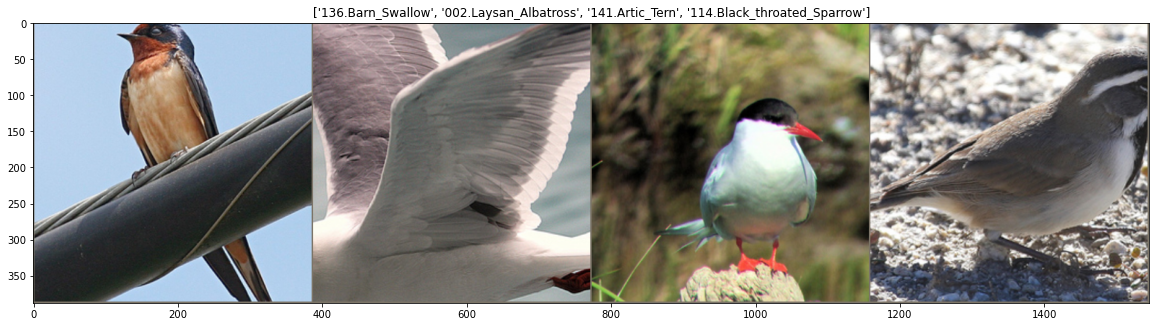

In [6]:
# Check the augmentations
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
# Load the best model from file
model_ = torch.load(model_file)

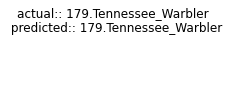

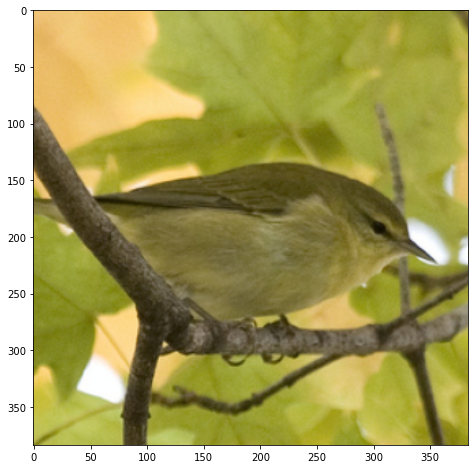

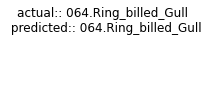

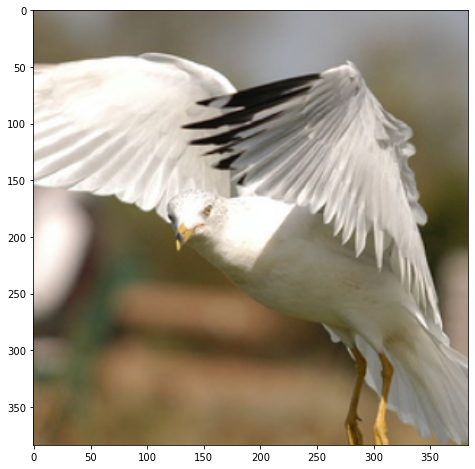

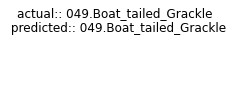

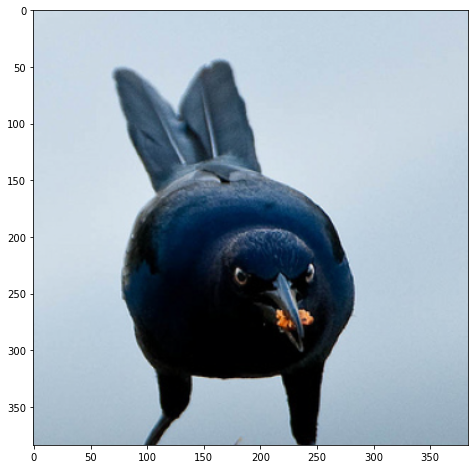

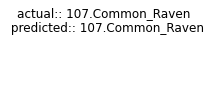

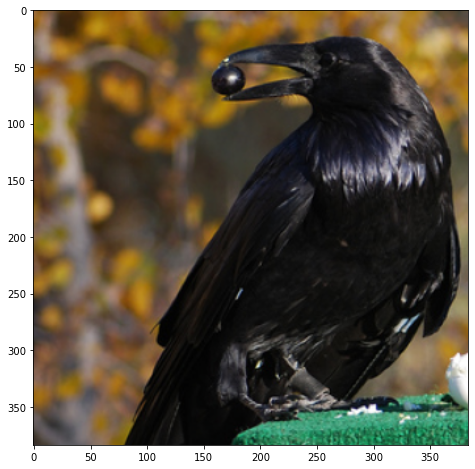

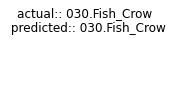

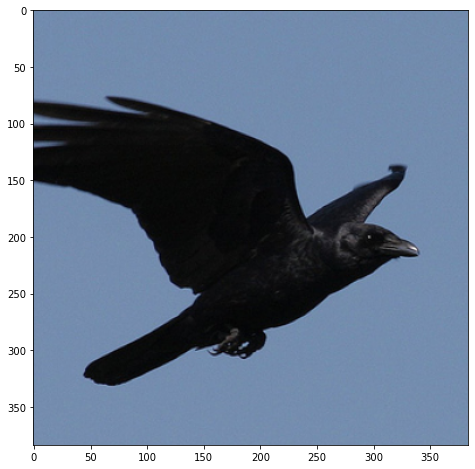

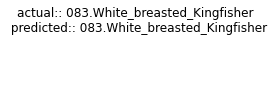

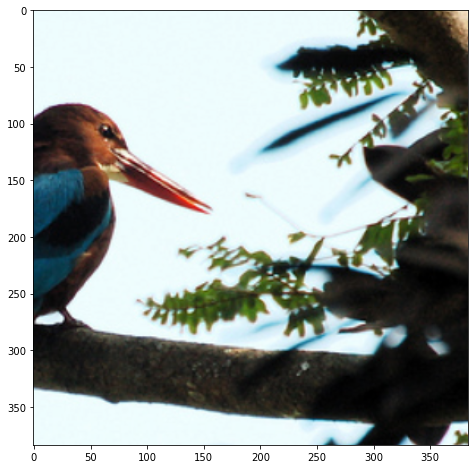

In [8]:
visualize_model(model=model_, class_names=class_names, device=device, dataloaders=dataloaders)

In [9]:
# Load model training history
history = unpickle(model_history)

In [10]:
for key in history.keys():
    print(' {} Type :: {}'.format(key,type(history[key][0])))

 epoch Type :: <class 'int'>
 train_loss Type :: <class 'float'>
 test_loss Type :: <class 'float'>
 train_acc Type :: <class 'torch.Tensor'>
 test_acc Type :: <class 'torch.Tensor'>


In [11]:
for key in history.keys():
    print(' {} Type :: {}'.format(key,type(history[key][0])))
    if (torch.is_tensor(history[key][0])) and (history[key][0].device.type == 'cuda'):
        print('Converting Tensor type from GPU to CPU')
        for i, item in enumerate(history[key]):
            history[key][i] = history[key][i].cpu().tolist()

 epoch Type :: <class 'int'>
 train_loss Type :: <class 'float'>
 test_loss Type :: <class 'float'>
 train_acc Type :: <class 'torch.Tensor'>
Converting Tensor type from GPU to CPU
 test_acc Type :: <class 'torch.Tensor'>
Converting Tensor type from GPU to CPU


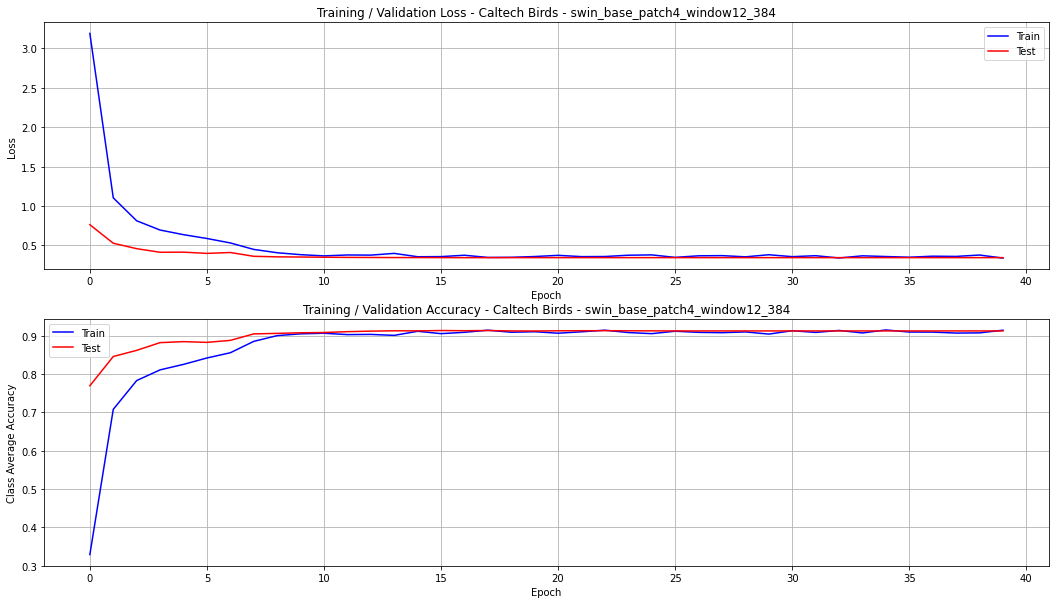

In [13]:
plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_loss'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_loss'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Loss - Caltech Birds - {}'.format(model))
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_acc'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_acc'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Class Average Accuracy')
plt.title('Training / Validation Accuracy - Caltech Birds - {}'.format(model))
plt.legend()

plt.show()

In [14]:
was_training = model_.training
model_.eval()
images_so_far = 0


print('Commencing predictions minibatch..', end='')
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        if i % 25 == 0:
            print('{}..'.format(i), end='')

        inputs = inputs.to(device)
        labels = labels.to(device)
        

        outputs = model_(inputs)
        _, preds = torch.max(outputs, 1)

        if i == 0:
            labels_truth = labels.cpu().numpy()
            labels_pred = preds.cpu().numpy()
            scores_pred = outputs.cpu().numpy()
        else:
            labels_truth = np.concatenate((labels_truth,labels.cpu().numpy()))
            labels_pred = np.concatenate((labels_pred,preds.cpu().numpy()))
            scores_pred= np.concatenate((scores_pred,outputs.cpu().numpy()))

print('Complete.')

results_dict = {'labels truth' : labels_truth, 'labels pred' : labels_pred, 'scores pred' : scores_pred}

Commencing predictions minibatch..0..25..50..75..100..125..150..175..200..225..250..275..300..325..350..375..400..425..450..475..500..525..550..575..600..625..650..675..700..725..750..775..800..825..850..875..900..925..950..975..1000..1025..1050..1075..1100..1125..1150..1175..1200..1225..1250..1275..1300..1325..1350..1375..1400..1425..Complete.


In [15]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [16]:
print(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names))

                                    precision    recall  f1-score   support

        001.Black_footed_Albatross       1.00      0.90      0.95        30
              002.Laysan_Albatross       1.00      0.90      0.95        30
               003.Sooty_Albatross       0.85      1.00      0.92        28
             004.Groove_billed_Ani       0.97      0.97      0.97        30
                005.Crested_Auklet       1.00      0.93      0.96        14
                  006.Least_Auklet       1.00      1.00      1.00        11
               007.Parakeet_Auklet       1.00      1.00      1.00        23
             008.Rhinoceros_Auklet       0.86      1.00      0.92        18
              009.Brewer_Blackbird       0.67      0.69      0.68        29
          010.Red_winged_Blackbird       0.97      1.00      0.98        30
               011.Rusty_Blackbird       0.95      0.63      0.76        30
       012.Yellow_headed_Blackbird       0.96      1.00      0.98        26
           

In [17]:
class_report_df = pd.DataFrame(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names, output_dict=True))
class_report_df

001.Black_footed_Albatross  002.Laysan_Albatross  \
precision                    1.000000              1.000000   
recall                       0.900000              0.900000   
f1-score                     0.947368              0.947368   
support                     30.000000             30.000000   

           003.Sooty_Albatross  004.Groove_billed_Ani  005.Crested_Auklet  \
precision             0.848485               0.966667            1.000000   
recall                1.000000               0.966667            0.928571   
f1-score              0.918033               0.966667            0.962963   
support              28.000000              30.000000           14.000000   

           006.Least_Auklet  007.Parakeet_Auklet  008.Rhinoceros_Auklet  \
precision               1.0                  1.0               0.857143   
recall                  1.0                  1.0               1.000000   
f1-score                1.0                  1.0               0.923077   
support                11.0                 23.0              18.000000   

           009.Brewer_Blackbird  010.Red_winged_Blackbird  ...  \
precision              0.666667                  0.967742  ...   
recall                 0.689655                  1.000000  ...   
f1-score               0.677966                  0.983607  ...   
support               29.000000                 30.000000  ...   

           194.Cactus_Wren  195.Carolina_Wren  196.House_Wren  197.Marsh_Wren  \
precision         1.000000           0.789474        0.961538        1.000000   
recall            0.966667           1.000000        0.833333        0.866667   
f1-score          0.983051           0.882353        0.892857        0.928571   
support          30.000000          30.000000       30.000000       30.000000   

           198.Rock_Wren  199.Winter_Wren  200.Common_Yellowthroat  accuracy  \
precision       0.933333         0.818182                      1.0  0.913704   
recall          0.933333         0.900000                      1.0  0.913704   
f1-score        0.933333         0.857143                      1.0  0.913704   
support        30.000000        30.000000                     30.0  0.913704   

             macro avg  weighted avg  
precision     0.916949      0.916776  
recall        0.914590      0.913704  
f1-score      0.913714      0.913190  
support    5794.000000   5794.000000  

[4 rows x 203 columns]

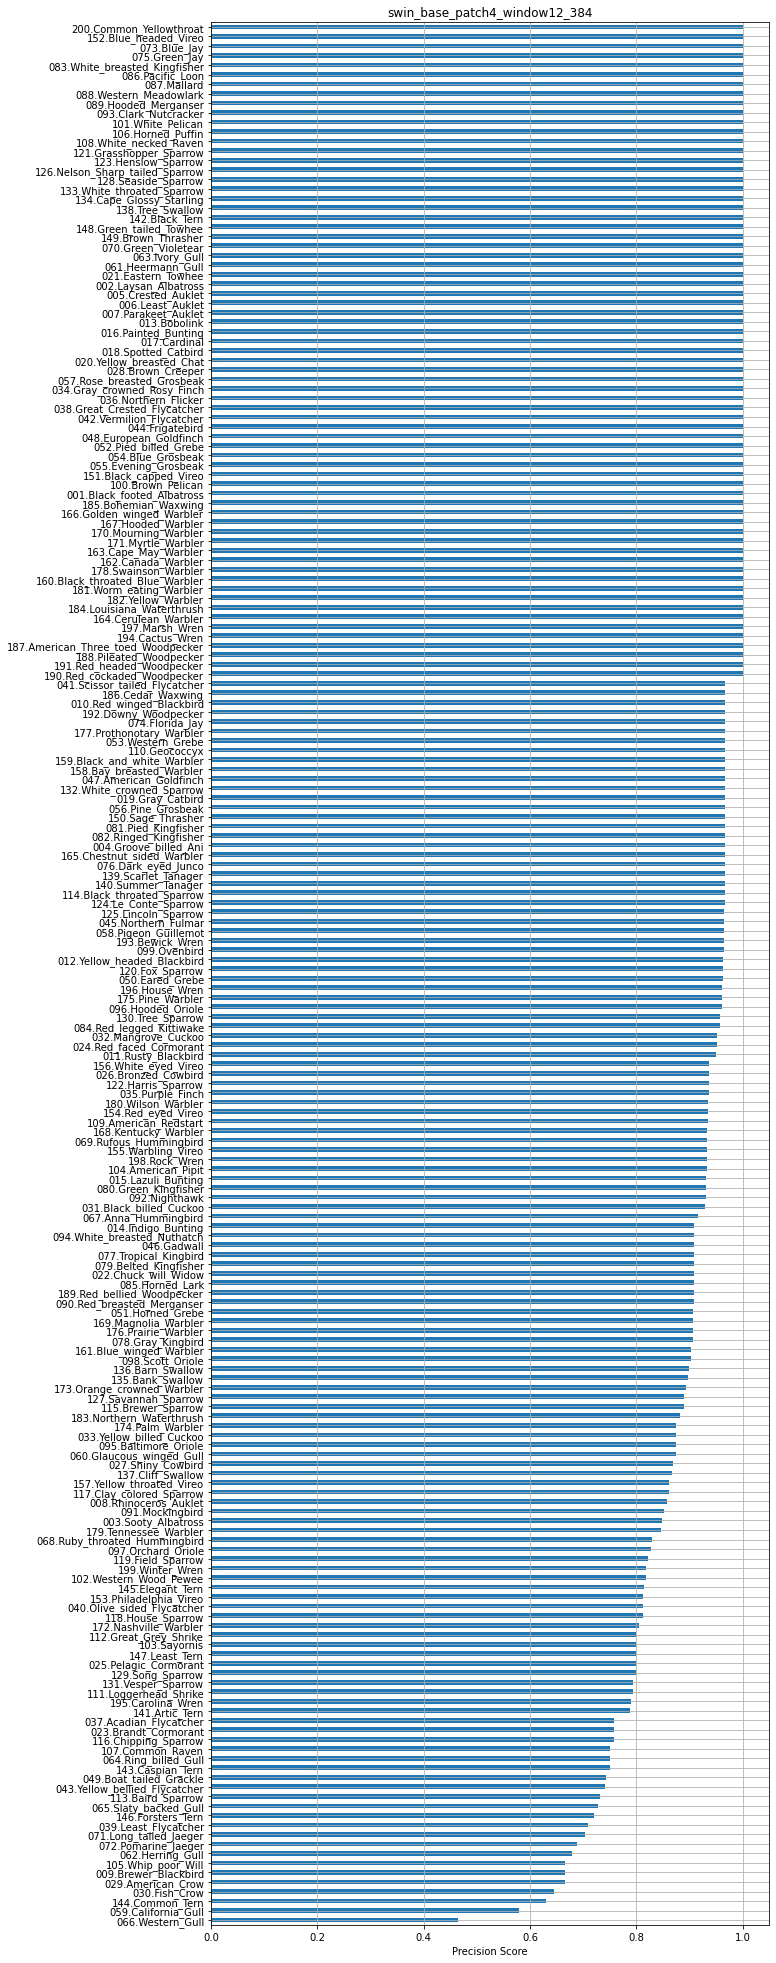

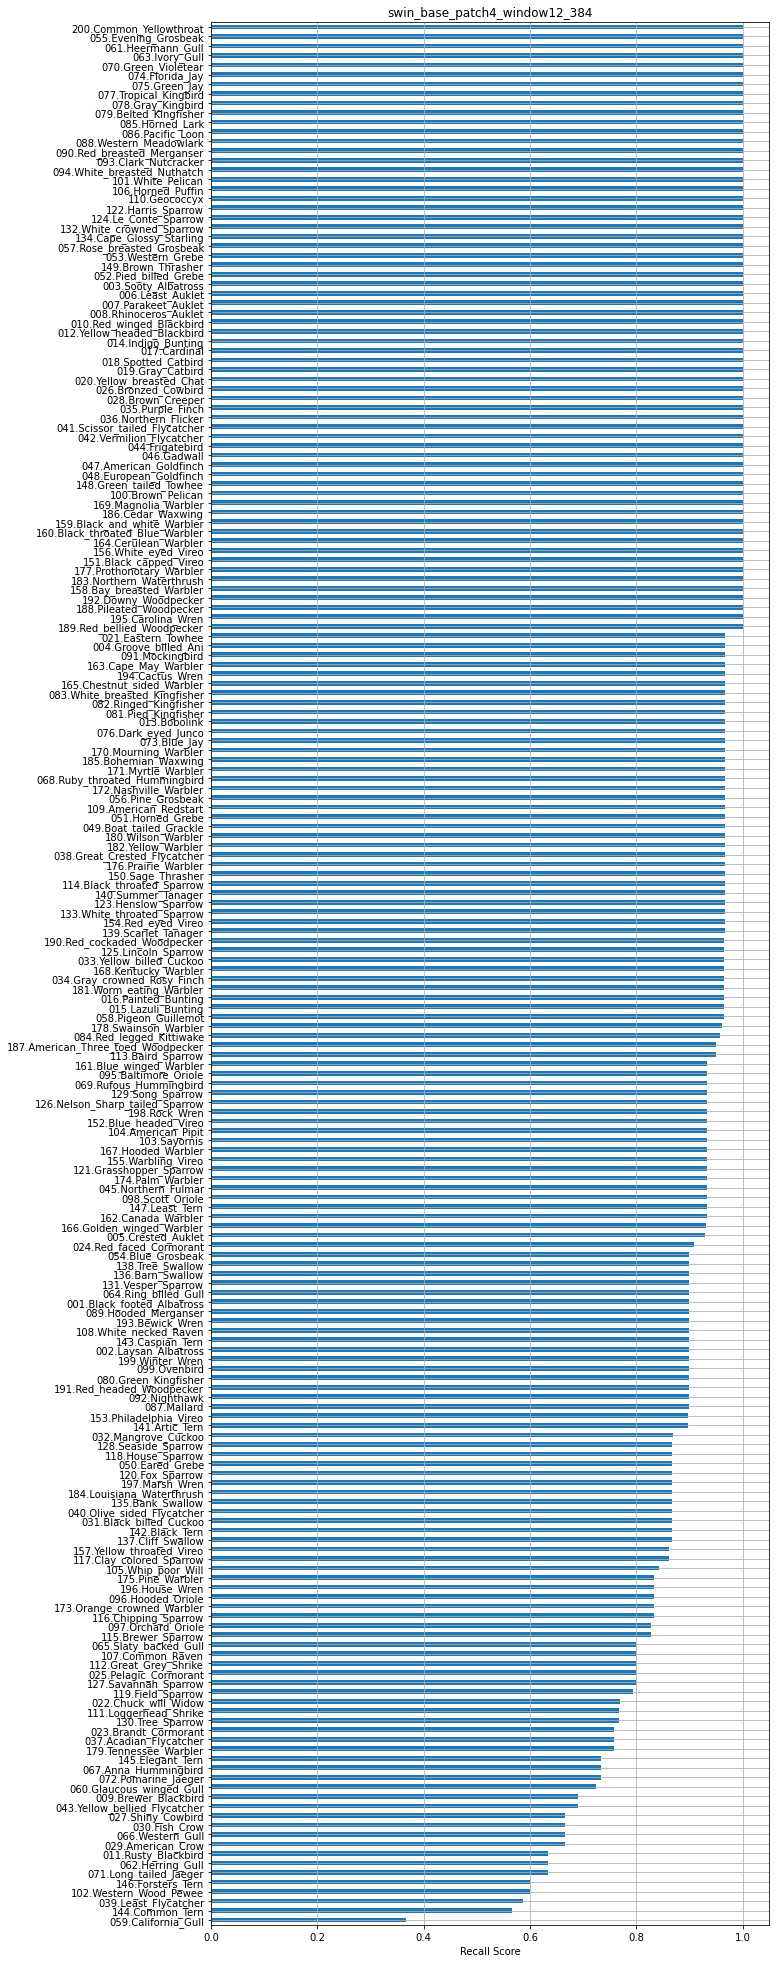

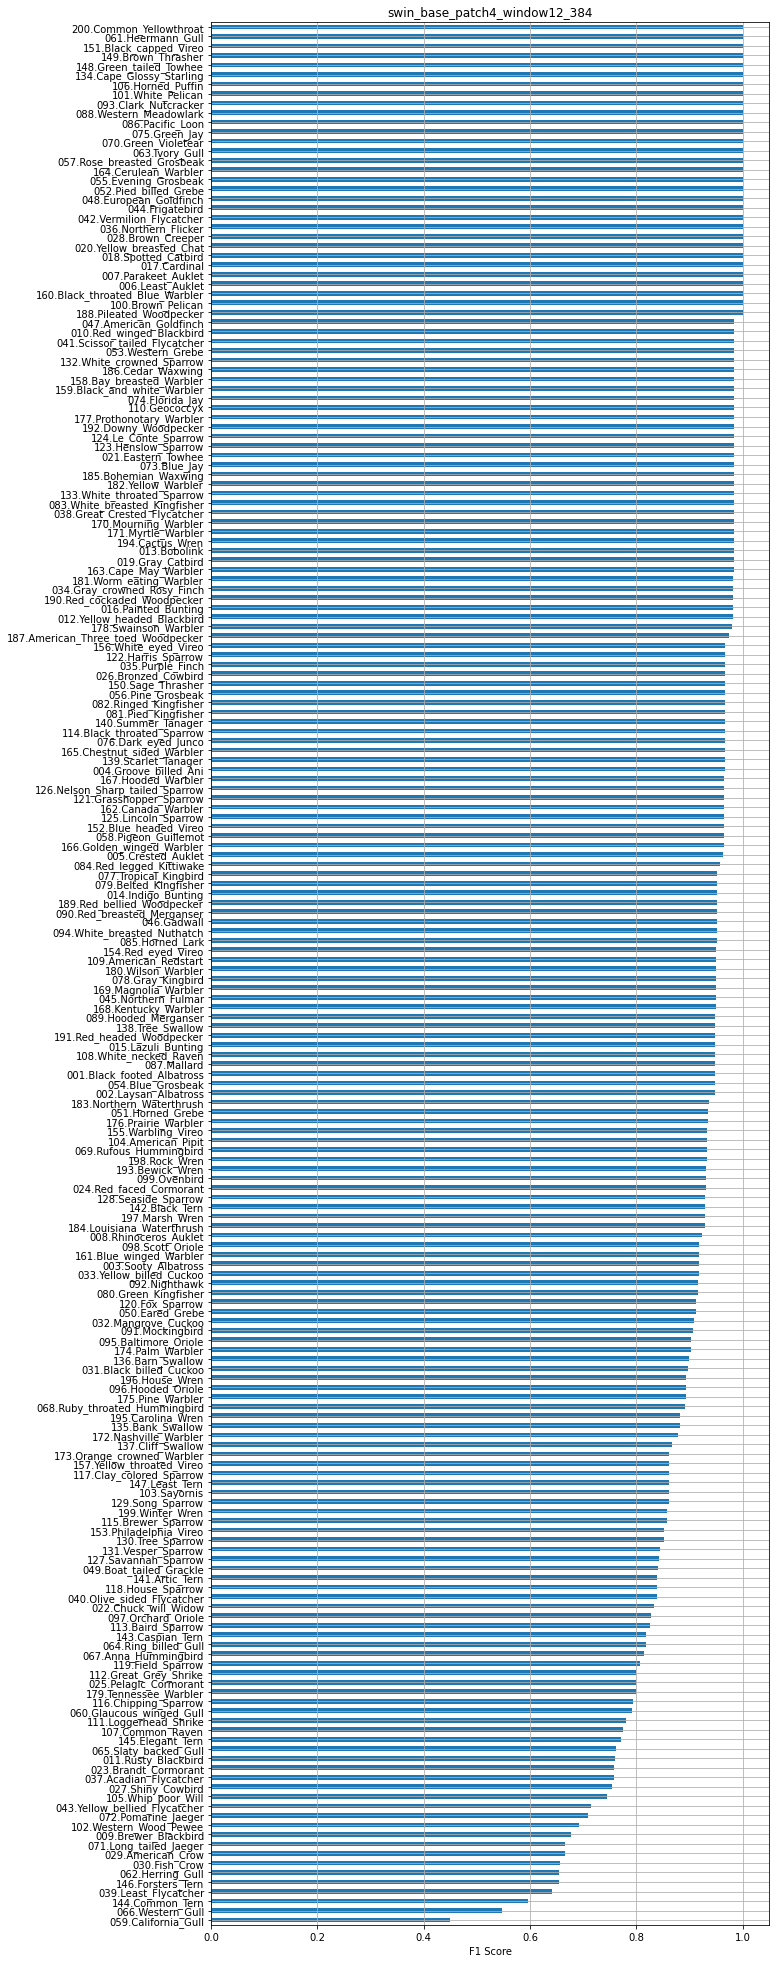

In [18]:
plt.figure(figsize=(10,35))
class_report_df.transpose()['precision'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Precision Score')
plt.grid(True)
plt.title(model)

plt.figure(figsize=(10,35))
class_report_df.transpose()['recall'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Recall Score')
plt.title(model)
plt.grid(True)

plt.figure(figsize=(10,35))
class_report_df.transpose()['f1-score'][:-3].sort_values().plot(kind='barh')
plt.xlabel('F1 Score')
plt.title(model)
plt.grid(True)

plt.show()

In [19]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true=labels_truth, y_pred=labels_pred), index=class_names, columns=class_names)

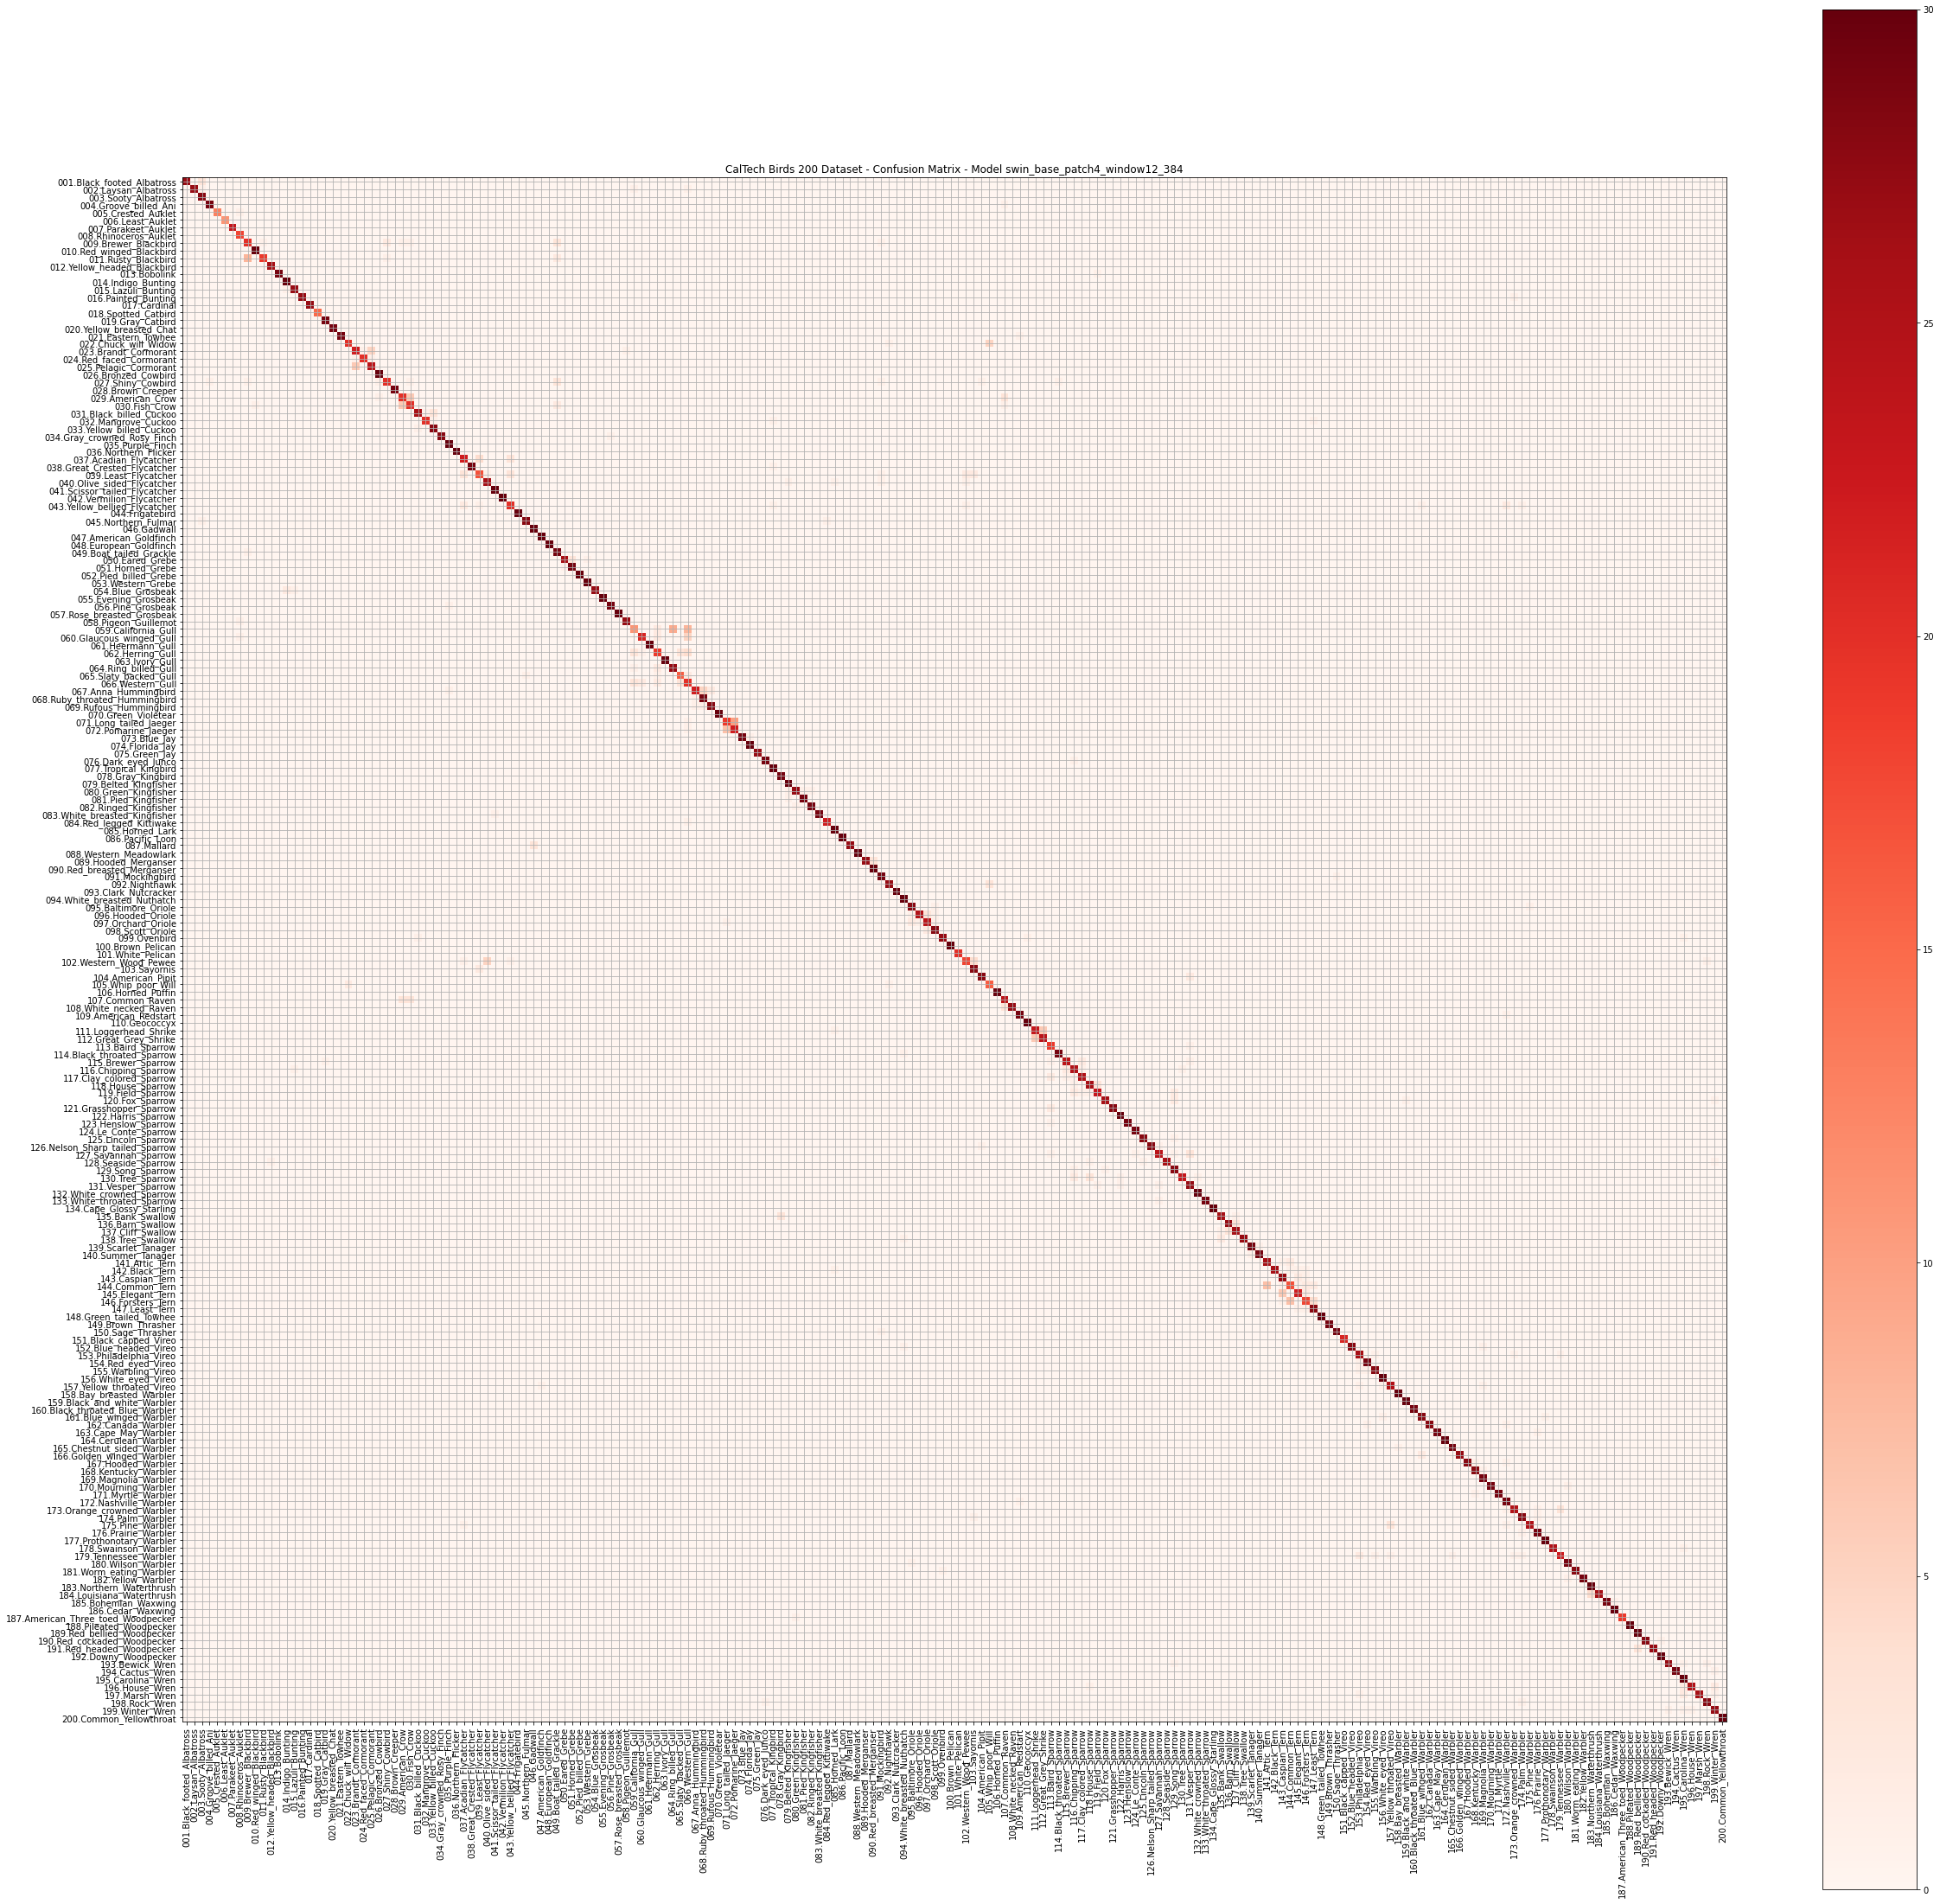

In [20]:
plt.figure(figsize=(40,40))
plt.imshow(confusion_matrix_df, cmap='Reds')
plt.xticks(np.arange(0,len(class_names),1), class_names, rotation=90)
plt.yticks(np.arange(0,len(class_names),1), class_names)
plt.colorbar()
plt.grid(True)
plt.title('CalTech Birds 200 Dataset - Confusion Matrix - Model {}'.format(model))
plt.show()

In [21]:
class_report_df.to_pickle(os.path.join(output_dir,'classification_report.pkl'))
confusion_matrix_df.to_pickle(os.path.join(output_dir,'confusion_matrix.pkl'))
save_pickle(pkl_object=results_dict, fname=os.path.join(output_dir,'model_results.pkl'))

In [22]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [23]:
results_dict.keys()

dict_keys(['labels truth', 'labels pred', 'scores pred'])

In [24]:
results_dict['scores pred'].shape

(5794, 200)

In [25]:
misclass_scores = []
for i in range(results_dict['scores pred'].shape[0]):
    if results_dict['labels truth'][i] != results_dict['labels pred'][i]:
        misclass_scores.append( 
            {
                'label truth' : results_dict['labels truth'][i],
                'label pred' : results_dict['labels pred'][i],
                'scores' : softmax(results_dict['scores pred'][i,:])
            }
        )

In [26]:
pd.DataFrame(misclass_scores)

label truth  label pred  \
0            118         128   
1             26          29   
2            127         117   
3             65          58   
4             29         106   
..           ...         ...   
495           10           8   
496          137         134   
497          189         191   
498           70          71   
499          143         145   

                                                scores  
0    [4.9730474e-08, 2.705349e-08, 5.79923e-08, 1.4...  
1    [4.6237633e-07, 1.695597e-07, 5.465892e-06, 0....  
2    [3.5938208e-06, 1.5315651e-08, 1.1618042e-07, ...  
3    [5.8381363e-07, 0.0007221373, 1.7383549e-06, 4...  
4    [1.3739193e-06, 2.6984376e-08, 2.9294128e-07, ...  
..                                                 ...  
495  [3.5531948e-09, 9.028133e-08, 4.9226765e-06, 2...  
496  [7.912937e-09, 9.957841e-09, 4.2729655e-09, 2....  
497  [2.5465903e-08, 2.1924474e-07, 1.0007074e-09, ...  
498  [5.6349672e-05, 3.7692607e-06, 2.9734703e-05, ...  
499  [1.06229685e-07, 1.3026613e-07, 6.532172e-08, ...  

[500 rows x 3 columns]

In [27]:
misclass_scores_array = []
for m in misclass_scores:
    misclass_scores_array.append( m['scores'] )
misclass_scores_array = np.asarray(misclass_scores_array)

In [28]:
misclass_scores_array.shape

(500, 200)

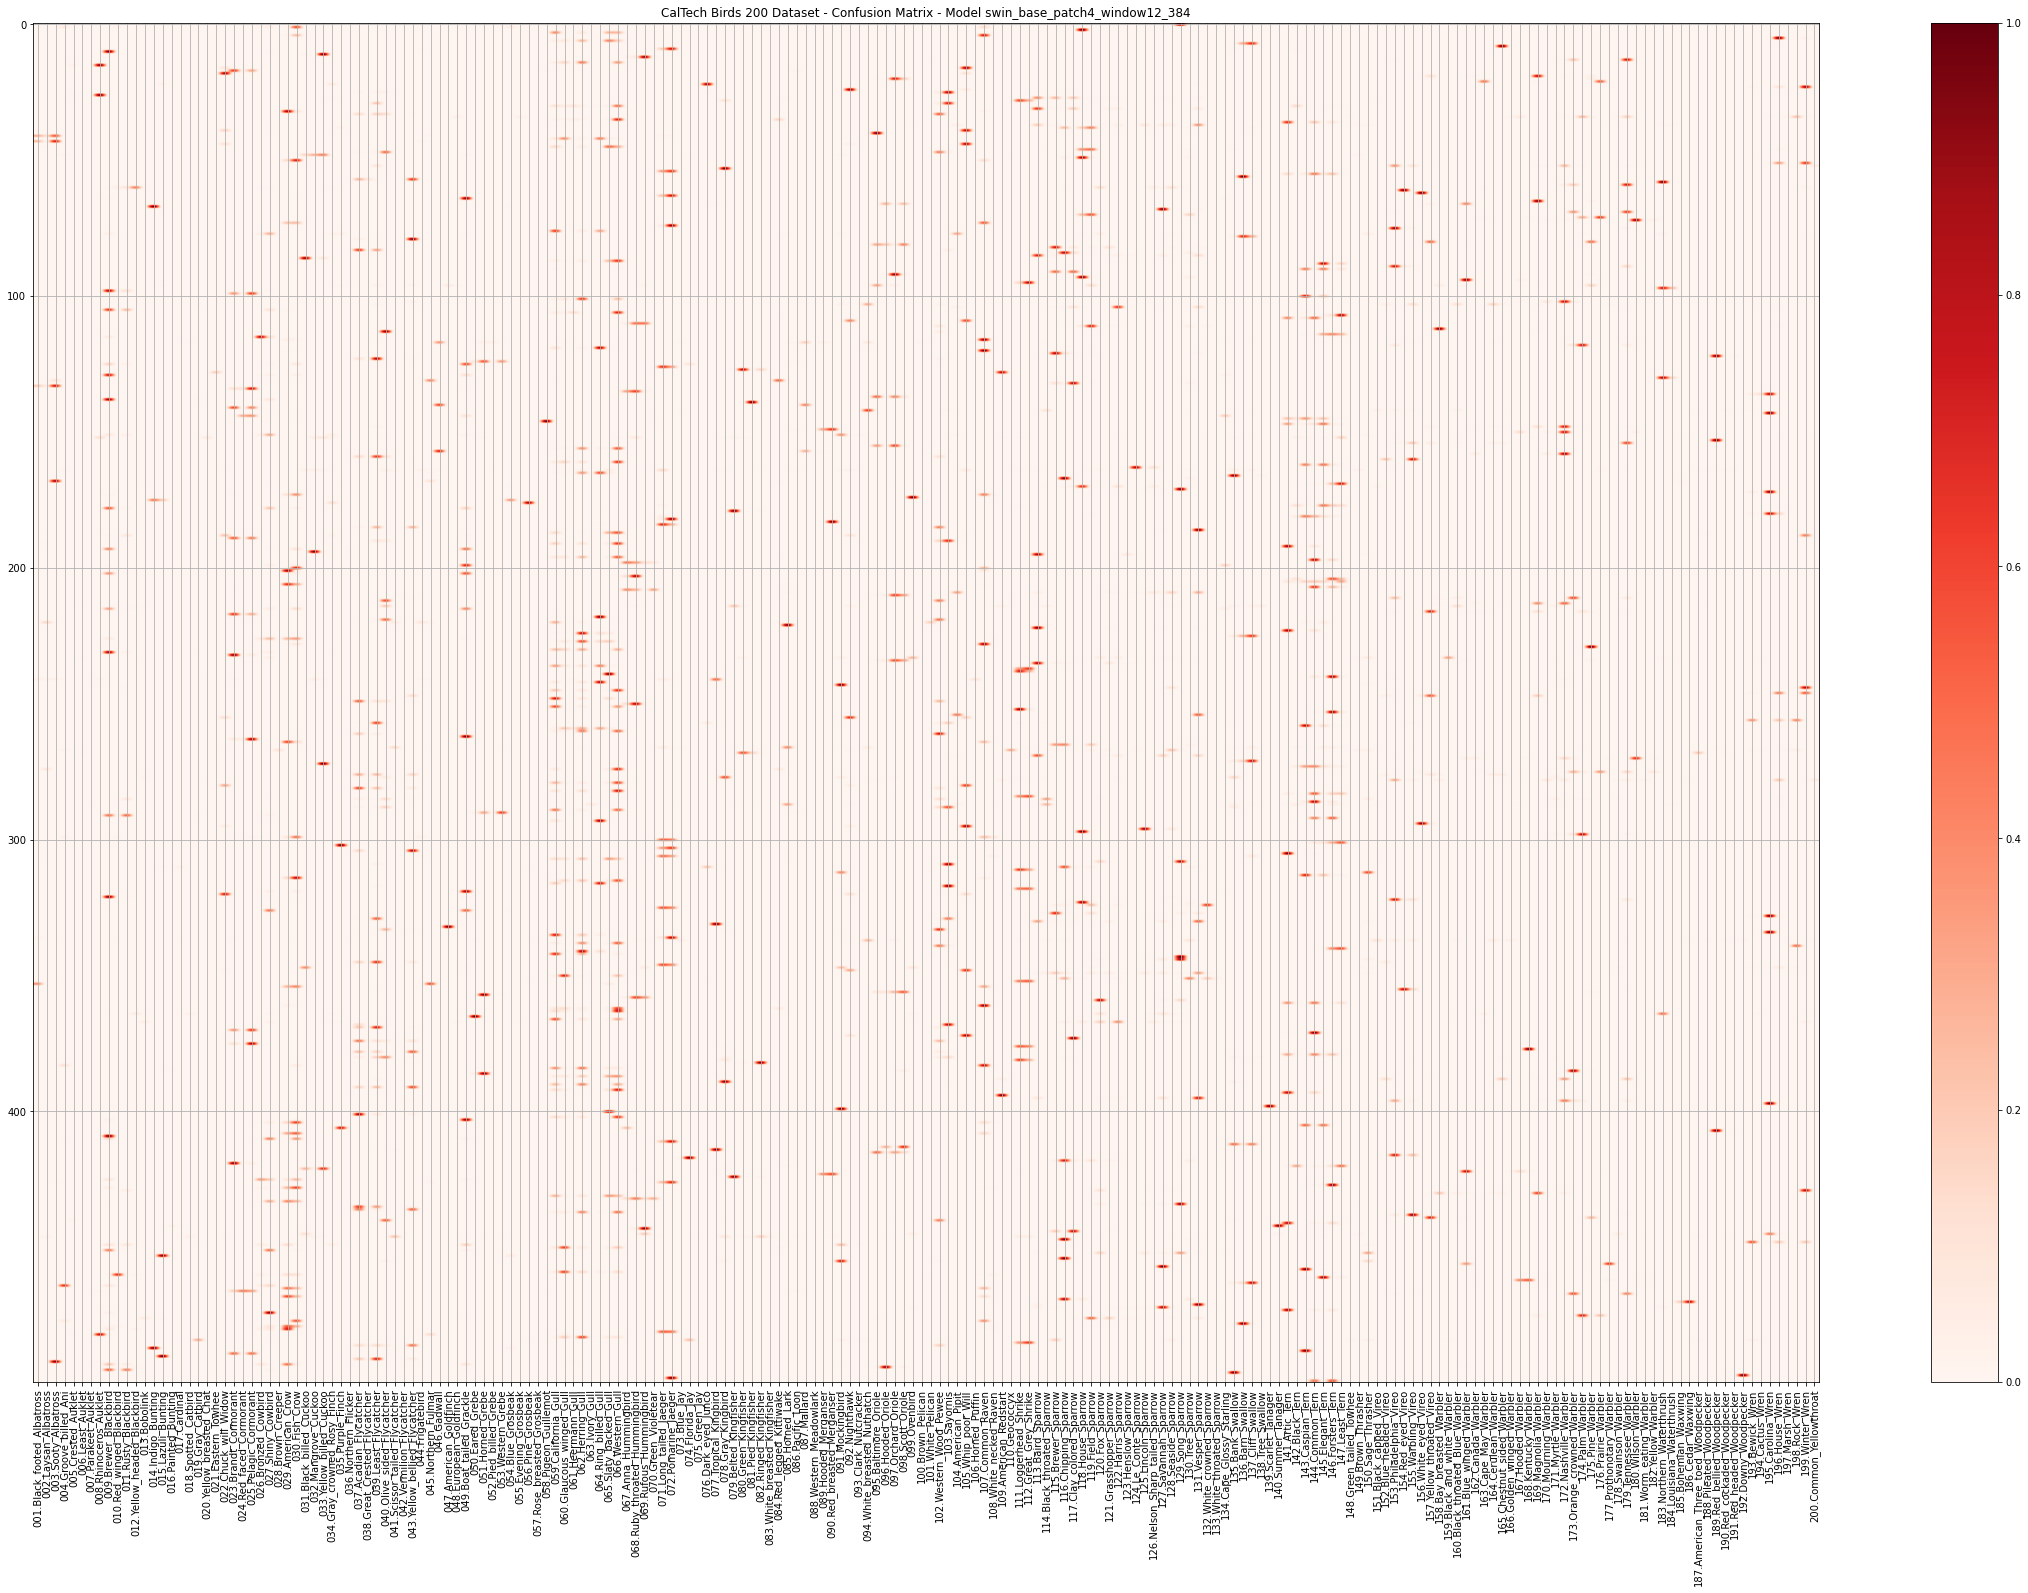

In [29]:
plt.figure(figsize=(40,25))
plt.imshow(misclass_scores_array, cmap='Reds', aspect='auto')
plt.xticks(np.arange(0,len(class_names),1), class_names, rotation=90)
#plt.yticks(np.arange(0,len(class_names),1), class_names)
plt.colorbar()
plt.grid(True)
plt.title('CalTech Birds 200 Dataset - Confusion Matrix - Model {}'.format(model))
plt.clim([0,1.0])
plt.show()

In [30]:
test_img_i = 5

results = softmax(results_dict['scores pred'][test_img_i])

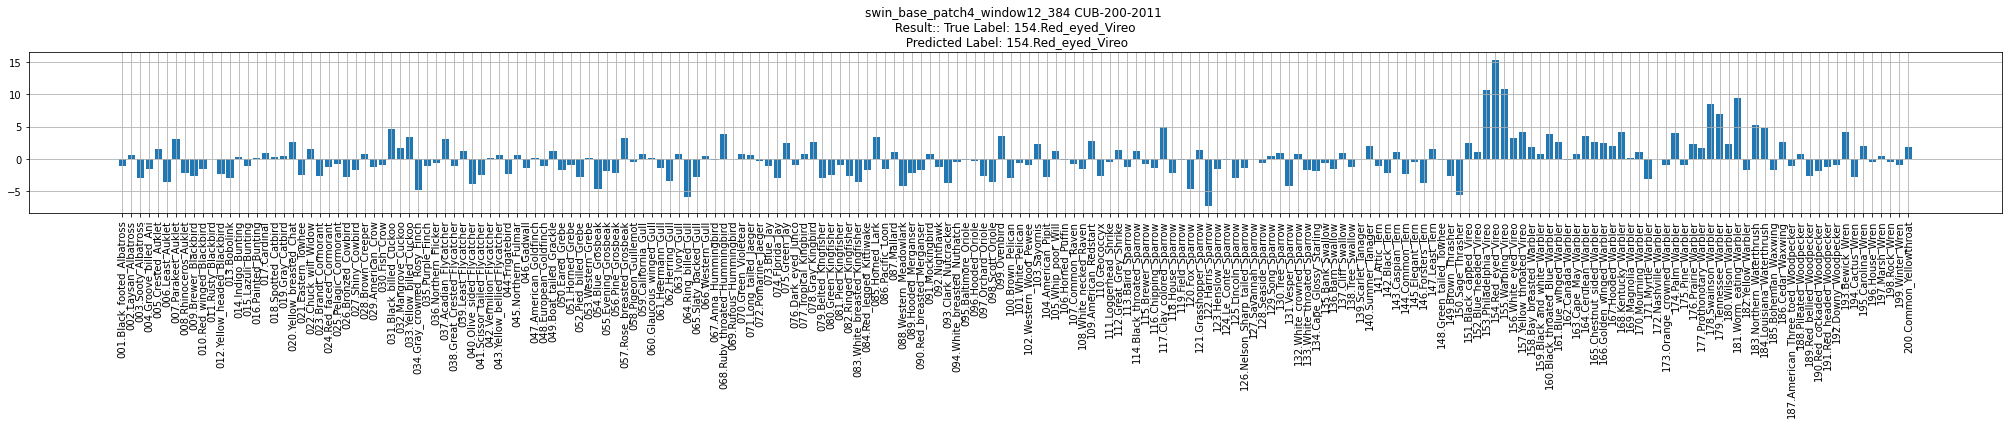

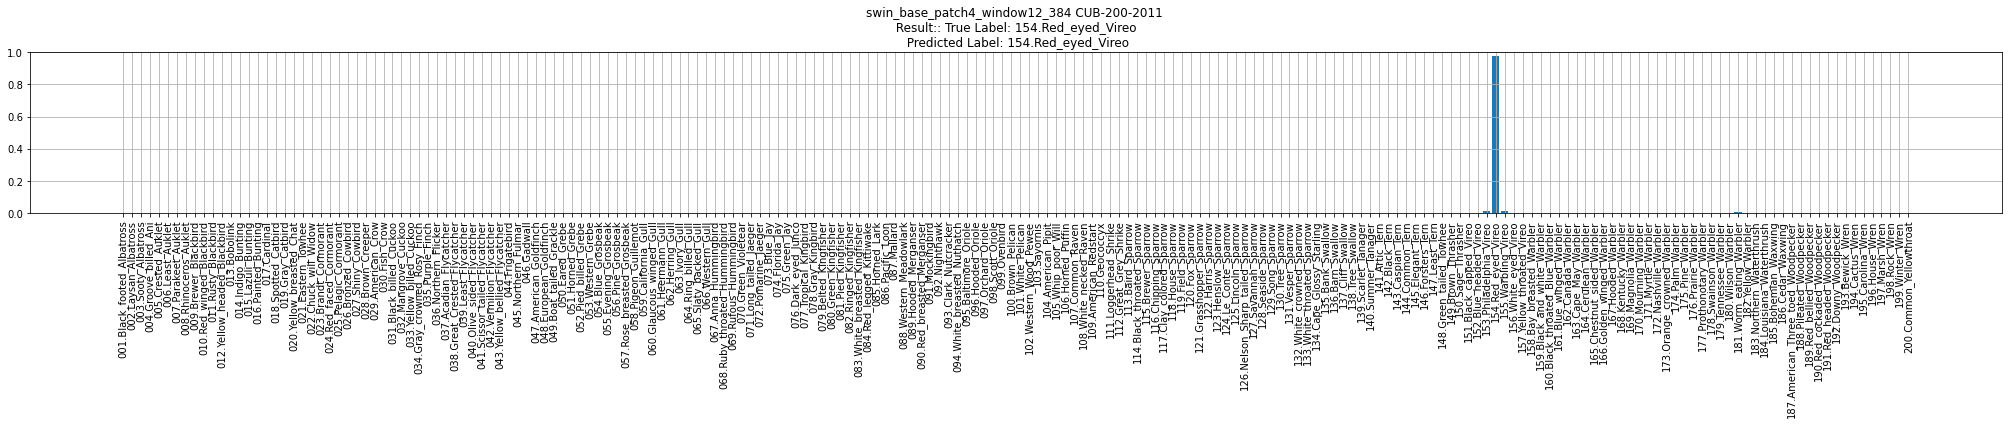

In [31]:
plt.figure(figsize=(28,6))
plt.bar(class_names,height=results_dict['scores pred'][test_img_i])
plt.xticks(rotation=90)
plt.title('{} CUB-200-2011 \n Result:: True Label: {} \n Predicted Label: {}'.format(model, class_names[results_dict['labels truth'][test_img_i]], class_names[results_dict['labels pred'][test_img_i]]))
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(28,6))
plt.bar(class_names,height=results)
plt.xticks(rotation=90)
plt.title('{} CUB-200-2011 \n Result:: True Label: {} \n Predicted Label: {}'.format(model, class_names[results_dict['labels truth'][test_img_i]], class_names[results_dict['labels pred'][test_img_i]]))
plt.grid(True)
plt.tight_layout()
plt.ylim([0.0, 1.0])
plt.show()